/var/tmp/ipykernel_1107990/2151526459.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


tensor([[0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000]], device='cuda:0')


/var/tmp/ipykernel_1107990/2151526459.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
/var/tmp/ipykernel_1107990/2151526459.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)


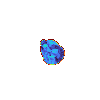

In [1]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import bayes3d as b
import jax.numpy as jnp
from random import randint
import pytorch3d.transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=2.5
)
fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)


def getProjectionMatrix(intrinsics):
    top = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    bottom = -top
    right = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * intrinsics.near / (right - left)
    P[1, 1] = 2.0 * intrinsics.near / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[2, 2] = z_sign * (intrinsics.far + intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[2, 3] = -2.0 * (intrinsics.far * intrinsics.near) / (intrinsics.far - intrinsics.near)
    P[3, 2] = z_sign
    return torch.transpose(P, 0, 1)

proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)

def posevec_to_matrix(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )
def apply_transform(points, transform):
    rels_ = torch.cat(
        (
            points,
            torch.ones((points.shape[0], 1),  device=device),
        ),
        1,
    )
    return torch.einsum("ij, aj -> ai", transform, rels_)[...,:3]
position = torch.tensor([0.0, 0.1, 0.2], device=device)
quat = torch.tensor([1.0, 0.1, 0.2, 0.3],device=device)
points = torch.zeros((5,3), device = device)
print(apply_transform(points, posevec_to_matrix(position, quat)))

camera_pose = jnp.eye(4)
view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose))),0,1).cuda()
raster_settings = GaussianRasterizationSettings(
    image_height=int(intrinsics.height),
    image_width=int(intrinsics.width),
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=torch.tensor([intrinsics.far, intrinsics.far, intrinsics.far]).cuda(),
    scale_modifier=1.0,
    viewmatrix=view_matrix,
    projmatrix=view_matrix @ proj_matrix,
    sh_degree=1,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)

model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(14).rjust(6, '0') + ".ply")
mesh = b.utils.load_mesh(mesh_path)
vertices = torch.tensor(np.array(jnp.array(mesh.vertices) / 1000.0),device=device)

def render(pos,quat):
    means3D = apply_transform(vertices, posevec_to_matrix(pos, quat))
    N = means3D.shape[0]
    means2D = torch.ones((N, 3),requires_grad=True, device=device)
    opacity = torch.rand((N, 1),requires_grad=True,device=device)
    scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)
    rotations = torch.rand((N, 4),requires_grad=True,device=device)

    data = rasterizer(
        means3D = means3D,
        means2D = means2D,
        shs = None,
        colors_precomp = means3D[:,2:3],
        opacities = opacity,
        scales = scales,
        rotations = rotations
    )
    return data

pos = torch.tensor([0.0, 0.0, 0.5],device=device)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)

color, radii =  render(pos, quat)
depth_image = np.moveaxis(color.detach().cpu().numpy(),0,-1)[...,2]

# out_weights = out_weights.detach().cpu().numpy()
# tensor_ranges = tensor_ranges.detach().cpu().numpy()
# gaussian_sorted = gaussian_sorted.detach().cpu().numpy()


viz_gt = b.get_depth_image(depth_image)
viz_gt

In [2]:
color.shape

torch.Size([3, 100, 100])

In [1]:
BLOCK_X = 16
BLOCK_Y = 16
BLOCK_SIZE = BLOCK_X* BLOCK_Y
num_tiles_x = int((intrinsics.width + BLOCK_X - 1) / BLOCK_X)
num_tiles_y = int((intrinsics.height + BLOCK_Y - 1) / BLOCK_Y)
num_tiles = num_tiles_x * num_tiles_y


# Print all relevant info.

assert tensor_ranges.shape[0] == num_tiles * 2
num_gaussians = gaussian_sorted.shape[0]
assert out_weights.shape[0] == num_gaussians * BLOCK_X* BLOCK_Y

img = np.zeros((intrinsics.height, intrinsics.width))


for tile in tqdm(range(num_tiles)):
    print(f"TILE {tile}")
    range_x, range_y = tensor_ranges[2*tile], tensor_ranges[2*tile + 1]
    start_index = (BLOCK_SIZE * range_x)
    print(start_index)
    num_gaussians_in_this_block = range_y - range_x
    print(f"NUM GAUSSIANS IN THIS BLOCK {num_gaussians_in_this_block}")
    if num_gaussians_in_this_block == 0:
        continue
    for ii in range(BLOCK_X):
        for jj in range(BLOCK_Y):
            pixel_index_in_block = jj * BLOCK_X + ii
            u,v = (start_index + pixel_index_in_block * num_gaussians_in_this_block, start_index + (pixel_index_in_block + 1) * num_gaussians_in_this_block)
            print(u,v)
            weights = out_weights[u:v]
            maximum_weight = weights.max()
            img[tile // num_tiles_y * BLOCK_Y + jj, tile % num_tiles_x * BLOCK_X + ii] = maximum_weight
plt.matshow(img)
plt.colorbar()

NameError: name 'intrinsics' is not defined

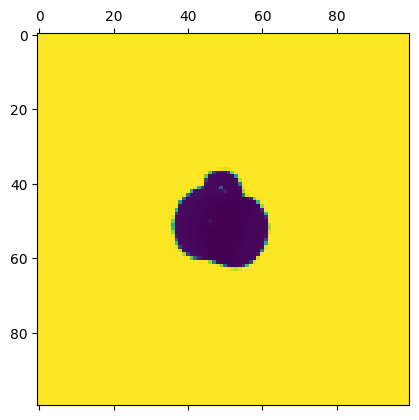

In [16]:
plt.matshow(depth_image)

In [4]:
tensor_ranges.shape

torch.Size([98])

In [13]:

color, radii, num_rendered, tiles_depth_sorted,gaussian_sorted,tensor_ranges,alpha_tensor=  render(pos, quat)
depth_image = np.moveaxis(color.detach().cpu().numpy(),0,-1)[...,2]
viz_gt = b.get_depth_image(depth_image)
viz_gt


hello
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  4849
4849  11793
0  0
0  0
0  0
0  0
0  0
11793  19001
19001  28809
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
hello


/var/tmp/ipykernel_787001/2567456983.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor( 0.0025 * torch.rand((N, 3)),requires_grad=True,device=device)


tensor([ 6916, 15673,  7166, 15981, 15982,  7164, 15980,  7177, 15992,  7151,
        15960, 15961, 15962,  7492, 16404, 16405,  7160,  7167, 15983,  7129,
         7188,  7296, 16124, 16125,  7494, 16407, 16408,  7162, 15978,  7502,
        16412,  7155, 15968,  7183, 15998,  7508, 16414, 16415,  7154, 15967,
         7165,  7503, 16413,  7300, 16131, 16132,  7291, 16118,  7493, 16406,
         7479, 16394,  7441, 16349, 16350,  7153, 15965, 15966,  7452, 16361,
         7152, 15963, 15964,  7125, 15928, 15929,  7170, 15988, 15989,  7146,
        15954, 15955,  7128, 15934, 15935, 15936,  7120, 15924, 15925,  7450,
        16360,  7124,  7354, 16228, 16229,  7293, 16120,  7169, 15986, 15987,
         7837, 16744,  7100, 15894, 15895, 15896, 15897, 15898],
       dtype=torch.int32)

In [11]:
def signedToUnsigned(n, byte_count): 
  return int.from_bytes(n.to_bytes(byte_count, 'little', signed=True), 'little', signed=False)

In [15]:
a = np.array([-7]).astype(np.int32)
a.astype(np.uint32)

array([4294967289], dtype=uint32)

In [18]:
type(4)

int

In [19]:
signedToUnsigned(int(t[0]),4)

7789

In [20]:
int(t[0])

7789

In [10]:
.view(np.uint32)

array([ 7789, 16670, 16671,  7798, 16681, 16682,  7262, 16079,  7257,
       16071, 16072,  7225, 16044, 16045,  7258, 16073, 16074,  7799,
       16683,  7791, 16673,  7763, 16636, 16637,  7793, 16675,  7261,
       16077, 16078,  7224, 16043,  7790, 16672,  7235,  7775, 16658,
       16659,  7248, 16062, 16063,  7249, 16064, 16065,  7766, 16643,
        7176,  7229,  7780, 16664,  7251,  7797,  7776, 16660,  7399,
       16290,  7230,  7172,  7097, 15892, 15893,  7247,  7222, 16041,
       16042,  7231,  7218,  7779,  7091, 15884, 15885,  7214, 16033,
       16034,  7244,  7163,  7223,  7217, 16036,  7072, 15851, 15852,
        7219, 16037,  7227, 16046,  7401, 16293, 16294,  7211, 16029,
        7149, 15957, 15958,  7228, 16047, 16048,  7209,  7252],
      dtype=uint32)

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


/var/tmp/ipykernel_779547/2926322865.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


tensor([[0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000],
        [0.0000, 0.1000, 0.2000]], device='cuda:0')


In [7]:
vertices.shape

torch.Size([16763, 3])

: 

In [ ]:
tensor_ranges

In [ ]:
tensor_ranges

In [ ]:
print(num_rendered)
print(tiles_depth_sorted.shape)
print(gaussian_sorted.shape)
print(alpha_tensor.shape)

In [ ]:
fig = plt.figure()
plt.plot(alpha_tensor.detach().cpu().numpy())

In [ ]:
tiles_depth_sorted

In [ ]:
gaussian_sorted

In [ ]:
gaussian_sorted.max()

In [ ]:
tiles_depth_sorted

In [ ]:
gaussian_sorted

In [ ]:
tiles_depth_sorted

In [ ]:
torch.unique(tiles_depth_sorted).shape

In [ ]:
16*16

In [ ]:
gaussian_sorted.max()

In [ ]:
tiles_depth_sorted

In [ ]:
pos = torch.tensor([0.0, 0.0, 0.5],device=device)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device)

data =  render(pos, quat).detach()
depth_image = np.moveaxis(gt_rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz_gt = b.get_depth_image(depth_image)
viz_gt


In [ ]:
pos = torch.tensor([0.0, 0.0, 0.5],device=device, requires_grad=True)
quat =  torch.tensor(quat + torch.rand(4,device=device)*0.1,device=device, requires_grad=True)
rendered_image =  render(pos, quat)
depth_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz = b.get_depth_image(depth_image)
parameters_over_time = []
losses_over_time = []
b.hstack_images([viz, viz_gt])


In [ ]:

optimizer = torch.optim.Adam([
    {'params': [pos], 'lr': 0.0001, "name": "pos"},
    {'params': [quat], 'lr': 0.001, "name": "quat"},
], lr=0.0, eps=1e-15)


pbar = tqdm(range(25))
for _ in pbar:
    rendered_image =  render(pos, quat)
    loss = torch.abs(gt_rendered_image - rendered_image).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    parameters_over_time.append((pos.detach().clone(),quat.detach().clone()))
    losses_over_time.append(loss.item())
    pbar.set_description(f"{loss.item()}")

depth_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
b.show_cloud("1", b.unproject_depth_jit(depth_image, intrinsics).reshape(-1,3))
viz = b.get_depth_image(depth_image)
b.hstack_images([viz, viz_gt])



In [ ]:
T = 0
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(2,2,1)
ax.set_title("Target")
gt_image = np.moveaxis(gt_rendered_image.detach().cpu().numpy(),0,-1)[...,2]
img1 = ax.imshow(b.preprocess_for_viz(gt_image),cmap=b.cmap)
ax = fig.add_subplot(2,2,2)
parameters = parameters_over_time[T]
rendered_image = render(*parameters)
rendered_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
img2 = ax.imshow(b.preprocess_for_viz(rendered_image),cmap=b.cmap)
title = ax.set_title(f"Reconstruction")
ax = fig.add_subplot(2,1,2)
line = ax.plot(jnp.arange(T), losses_over_time[:T])
# ax.set_yscale("log")
ax.set_title("Pixelwise MSE Loss")
# ax.set_ylim(0.01, 1000.0)
ax.set_xlabel("Iteration")
ax.set_xlim(0,len(losses_over_time))
fig.tight_layout()

buffs = []
for T in tqdm(range(0,len(losses_over_time),3)):
    parameters = parameters_over_time[T]
    rendered_image = render(*parameters)
    rendered_image = np.moveaxis(rendered_image.detach().cpu().numpy(),0,-1)[...,2]
    img2.set_array(b.preprocess_for_viz(rendered_image))
    line[0].set_xdata(jnp.arange(T))
    line[0].set_ydata(losses_over_time[:T])
    fig.canvas.draw()
    buffs.append(b.pil_image_from_matplotlib(fig))
buffs[-1]

In [ ]:
b.make_gif_from_pil_images(buffs, "optimization.gif")